In [ ]:
! pip install -q kaggle

In [ ]:
import tensorflow as tf
from tensorflow import keras
import os
import shutil
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image
import time

from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50, InceptionV3, ResNet101, DenseNet121, EfficientNetB0
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img
from tensorflow.keras.callbacks import EarlyStopping

## 1. LOADING DATASET FROM KAGGLE

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yolamx","key":"8a1f21e2b2a0b930f8ae0b97299d0755"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d andrewmvd/leukemia-classification
!unzip leukemia-classification.zip -d leukemia_dataset

Streaming output truncated to the last 5000 lines.
  inflating: leukemia_dataset/C-NMC_Leukemia/training_data/fold_2/all/UID_25_12_5_all.bmp  
  inflating: leukemia_dataset/C-NMC_Leukemia/training_data/fold_2/all/UID_25_12_6_all.bmp  
  inflating: leukemia_dataset/C-NMC_Leukemia/training_data/fold_2/all/UID_25_12_7_all.bmp  
  inflating: leukemia_dataset/C-NMC_Leukemia/training_data/fold_2/all/UID_25_13_1_all.bmp  
  inflating: leukemia_dataset/C-NMC_Leukemia/training_data/fold_2/all/UID_25_13_2_all.bmp  
  inflating: leukemia_dataset/C-NMC_Leukemia/training_data/fold_2/all/UID_25_13_3_all.bmp  
  inflating: leukemia_dataset/C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_1_all.bmp  
  inflating: leukemia_dataset/C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_2_all.bmp  
  inflating: leukemia_dataset/C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_3_all.bmp  
  inflating: leukemia_dataset/C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_4_all.bmp  
  inflating: leukemia_dataset

## ***INTRODUCTION***

1. Training data were split into 3 folders:
  - fold_0
  - fold_1
  - fold_2

Each folder contains cell images from **different patients** (no patient appears in more than one folder) which allows for reliable cross-validation and better model generalization.


2. **Class labels (healthy vs cancer cells):**
- **/all/** - cancer cells (ALL stands for Acute Lymphoblastic Leukemia)
  * fileNames: UID_P_N_C_all.bmp
- **/hem/** - healthy cells
  * fileNames: UID_HS_N_C_hem.bmp




In [ ]:
for dirname, _, filenames in os.walk('/content/leukemia_dataset'):
    print(dirname)

/content/leukemia_dataset
/content/leukemia_dataset/C-NMC_Leukemia
/content/leukemia_dataset/C-NMC_Leukemia/validation_data
/content/leukemia_dataset/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data
/content/leukemia_dataset/C-NMC_Leukemia/training_data
/content/leukemia_dataset/C-NMC_Leukemia/training_data/fold_1
/content/leukemia_dataset/C-NMC_Leukemia/training_data/fold_1/all
/content/leukemia_dataset/C-NMC_Leukemia/training_data/fold_1/hem
/content/leukemia_dataset/C-NMC_Leukemia/training_data/fold_0
/content/leukemia_dataset/C-NMC_Leukemia/training_data/fold_0/all
/content/leukemia_dataset/C-NMC_Leukemia/training_data/fold_0/hem
/content/leukemia_dataset/C-NMC_Leukemia/training_data/fold_2
/content/leukemia_dataset/C-NMC_Leukemia/training_data/fold_2/all
/content/leukemia_dataset/C-NMC_Leukemia/training_data/fold_2/hem
/content/leukemia_dataset/C-NMC_Leukemia/testing_data
/content/leukemia_dataset/C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data


In [ ]:
base_path = '/content/leukemia_dataset/C-NMC_Leukemia'

paths = []
labels = []

# all training data (fold_0, fold_1, fold_2)
train_path = os.path.join(base_path, 'training_data')

for fold in os.listdir(train_path): # fold_0, fold_1, fold_2
  fold_path = os.path.join(train_path, fold)
  if os.path.isdir(fold_path):
    for label in os.listdir(fold_path): # 'all' or 'hem'
      label_path = os.path.join(fold_path, label)
      if os.path.isdir(label_path):
        for f in os.listdir(label_path):
          if f.endswith('.bmp'):
            paths.append(os.path.join(label_path, f))
            labels.append(label)

# all testing data
test_path = os.path.join(base_path, 'testing_data', 'C-NMC_test_final_phase_data')

for fileName in os.listdir(test_path):
    if fileName.endswith('.bmp'):
        paths.append(os.path.join(test_path, fileName))
        labels.append('test')

# all validation data
val_img_path = os.path.join(base_path, 'validation_data', 'C-NMC_test_prelim_phase_data')

for fileName in os.listdir(val_img_path):
    if fileName.endswith('.bmp'):
        paths.append(os.path.join(val_img_path, fileName))
        labels.append('validation')

leukemia_df = pd.DataFrame({'paths': paths, 'labels': labels})

val_csv_path = os.path.join(base_path, 'validation_data', 'C-NMC_test_prelim_phase_data_labels.csv')
# show statistics
print("     Dataset statistics:")
print("*" * 30)
for label, count in leukemia_df["labels"].value_counts().items():
    print(f"- {label.capitalize():<12}: {count} images")
print("*" * 30)

print("\nTotal images in dataset:", leukemia_df.shape[0])
print(f"Number of entries (rows): {leukemia_df.shape[0]}")
print(f"Number of columns: {leukemia_df.shape[1]}")

# DataFrame size
print('\nleukemia_df.shape:', leukemia_df.shape)

     Dataset statistics:
******************************
- All         : 7272 images
- Hem         : 3389 images
- Test        : 2586 images
- Validation  : 1867 images
******************************

Total images in dataset: 15114
Number of entries (rows): 15114
Number of columns: 2

leukemia_df.shape: (15114, 2)


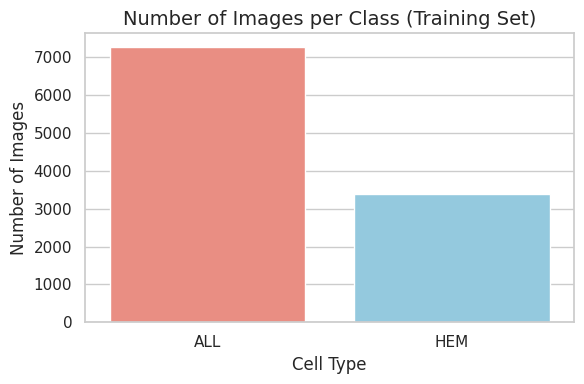

In [ ]:
# filter by label (all/hem)
train_df = leukemia_df[leukemia_df['labels'].isin(['all', 'hem'])]

# chart style
sns.set(style='whitegrid')

# count images for each class
class_counts = train_df['labels'].value_counts().reset_index()
class_counts.columns = ['labels', 'count']
class_counts['labels'] = class_counts['labels'].str.upper()

# create chart
plt.figure(figsize=(6, 4))
sns.barplot(
    data=class_counts,
    x='labels',
    y='count',
    hue='labels',
    palette={'ALL': 'salmon', 'HEM': 'skyblue'},
    legend=False           # ukrycie legendy (bo i tak są podpisy na osi X)
)

plt.title('Number of Images per Class (Training Set)', fontsize=14)
plt.xlabel('Cell Type', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)

plt.tight_layout()
plt.show()

There are 2x more cancer cells (ALL) than healthy cells (HEM) in the dataset which means the dataset is unbalanced and may further lead to model favorising the 'ALL' class in learning process.

### HEALTHY CELL and CANCER CELL SAMPLE

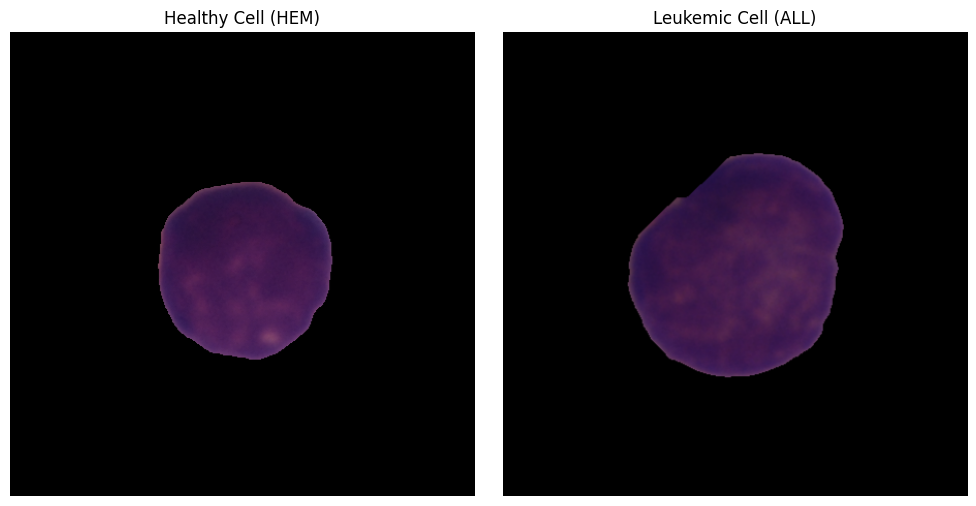

In [ ]:
# dataframes for healthy/cancer cells
all_df = leukemia_df[leukemia_df['labels'] == 'all']
hem_df = leukemia_df[leukemia_df['labels'] == 'hem']

# random sample from each class
all_sample = random.choice(all_df['paths'].tolist())
hem_sample = random.choice(hem_df['paths'].tolist())

# read images
hem_img = Image.open(hem_sample)
all_img = Image.open(all_sample)

# show images next to each other
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(hem_img)
plt.title('Healthy Cell (HEM)', fontsize=12)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(all_img)
plt.title('Leukemic Cell (ALL)', fontsize=12)
plt.axis('off')

plt.tight_layout()
plt.show()

## GENERATORS

### TRAINING DATA GENERATOR

In [ ]:
train_df = pd.DataFrame({'filename': paths, 'label': labels})
train_df = train_df[train_df['label'].isin(['all', 'hem'])]  # delete other than all/hem

In [ ]:
def get_train_generator(train_df, image_size=224, batch_size=32, normalize=False):
    if normalize:
        datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    else:
        datagen = ImageDataGenerator()

    return datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='filename',
        y_col='label',
        target_size=(image_size, image_size),
        class_mode='binary',
        batch_size=batch_size,
        shuffle=True
    )

### VALIDATION DATA GENERATOR

In [ ]:
val_df = pd.read_csv(val_csv_path)
val_df['filename'] = val_df['new_names']
val_df['label'] = val_df['labels'].map({0: 'hem', 1: 'all'})

In [ ]:
def get_val_generator(val_df, image_size=224, batch_size=32, normalize=False):
    val_img_path = os.path.join(base_path, 'validation_data', 'C-NMC_test_prelim_phase_data')
    if normalize:
        datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    else:
        datagen = ImageDataGenerator()

    return datagen.flow_from_dataframe(
        dataframe=val_df,
        directory=val_img_path,
        x_col='filename',
        y_col='label',
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )

### TESTING DATA GENERATOR - no labels

In [ ]:
test_folder = '/content/leukemia_dataset/C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data'
test_files = [f for f in os.listdir(test_folder) if f.endswith('.bmp')]

test_df = pd.DataFrame({'filename': test_files})

In [ ]:
def get_test_generator(test_df, normalize=False):
    test_folder = '/content/leukemia_dataset/C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data'
    if normalize:
        datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    else:
        datagen = ImageDataGenerator()

    return datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=test_folder,
        x_col='filename',
        y_col=None,
        target_size=(224, 224),
        batch_size=32,
        class_mode=None,
        shuffle=False
    )

### ALL SAMPLES COUNT

In [ ]:
train_generator = get_train_generator(train_df, normalize=False)
val_generator = get_val_generator(val_df, normalize=False)
test_generator = get_test_generator(test_df, normalize=False)

Found 10661 validated image filenames belonging to 2 classes.
Found 1867 validated image filenames belonging to 2 classes.
Found 2586 validated image filenames.


In [ ]:
print("Train samples:", train_generator.samples)
print("Val samples:", val_generator.samples)
print("Test samples:", test_generator.samples)

Train samples: 10661
Val samples: 1867
Test samples: 2586


## BUILD-MODEL FUNCTION

In [ ]:
# models that I'll be testing later
MODELS = {
    'ResNet50': ResNet50,
    'ResNet101': ResNet101,
    'InceptionV3': InceptionV3,
    'DenseNet121': DenseNet121,
    'EfficientNetB0': EfficientNetB0
}

# function to build different models -> returns compiled Keras model
def build_model(model_name='ResNet50',
                input_size=224, # image height/width
                weights='imagenet', # (not) using transfer learning
                trainable=False, # (not) fine-tune base model
                add_dropout=False, # (not) include Dropout layer
                dropout_rate=0.3, # dropout rate if Dropout is added
                learning_rate=0.001): # Adam learning rate

    if model_name not in MODELS:
        raise ValueError(f"Model '{model_name}' is not supported. Choose from: {list(MODELS.keys())}")

    BaseModel = MODELS[model_name]

    base_model = BaseModel(
        include_top=False,
        weights=weights,
        input_shape=(input_size, input_size, 3)
    )
    base_model.trainable = trainable

    layers = [
        base_model,
        GlobalAveragePooling2D()
    ]

    if add_dropout:
        layers.append(Dropout(dropout_rate))

    layers.append(Dense(1, activation='sigmoid'))

    model = Sequential(layers)

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

## TRAINING + TIME FUNCTION

In [ ]:
# function to train a model with given generators
# returns history + training time in seconds
def train_and_time(model,
                   train_generator,
                   val_generator,
                   epochs=10,
                   callbacks=None): # optional early stopping

    start_time = time.time()

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=callbacks
    )

    end_time = time.time()
    training_time = end_time - start_time

    return history, training_time

## CHART-DRAWING FUNCTION (for accuracy and loss)

In [ ]:
def plot_training_history(history, title_prefix="Model"):
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # accuracy chart
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title(f'{title_prefix} Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(epochs)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()

    # loss chart
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title(f'{title_prefix} Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

## 2. TRAINING ResNet50 MODEL (CPU + without transfer learning)

In [ ]:
# random 1000 samples for training
small_train_df = train_df[train_df['label'].isin(['all', 'hem'])].sample(n=1000, random_state=42).reset_index(drop=True)

# random 300 samples for validation
small_val_df = val_df.sample(n=300, random_state=42).reset_index(drop=True)

# using generators mentioned above
small_train_generator = get_train_generator(small_train_df, image_size=224, batch_size=32, normalize=False)
small_val_gen = get_val_generator(small_val_df, image_size=224, batch_size=32, normalize=False)

Found 1000 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.


In [ ]:
model = build_model(model_name='ResNet50',
                    input_size=224,
                    weights=None, # not using transfer learning, random weights
                    trainable=True,
                    add_dropout=False,
                    learning_rate=0.001)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 23,536,641 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
history, training_time = train_and_time(model,
                                        small_train_generator,
                                        small_val_gen,
                                        epochs=10)

print(f"\n Training time: {training_time/60:.2f} min")


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.6723 - loss: 1.3329 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 502s 16s/step - accuracy: 0.6738 - loss: 1.3178 - val_accuracy: 0.6500 - val_loss: 507.9454
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 499s 16s/step - accuracy: 0.7359 - loss: 0.5684 - val_accuracy: 0.6500 - val_loss: 31.8512
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 485s 15s/step - accuracy: 0.7864 - loss: 0.4588 - val_accuracy: 0.3267 - val_loss: 1.8037
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 503s 16s/step - accuracy: 0.8326 - loss: 0.3974 - val_accuracy: 0.6667 - val_loss: 0.6296
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 512s 16s/step - accuracy: 0.7976 - loss: 0.4503 - val_accuracy: 0.3500 - val_loss: 3.0486
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 532s 17s/step - accuracy: 0.8330 - loss: 0.4214 - val_accuracy: 0.6033 - val_loss: 4.2822
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 497s 16s/step - accuracy: 0.8158 - loss: 0.4687 - val_accuracy: 0.6767 - val_loss: 1.0294
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 494s 15s/step - accuracy: 0.8391 - loss: 0.3825 - val_accuracy: 0.6900 - v

In [ ]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
print("3a. CPU (no transfer learning):")
print(f"  - Final train accuracy: {final_train_acc:.4f}\n  - Final validation accuracy: {final_val_acc:.4f}")

3a. CPU (no transfer learning):
  - Final train accuracy: 0.8400
  - Final validation accuracy: 0.3300


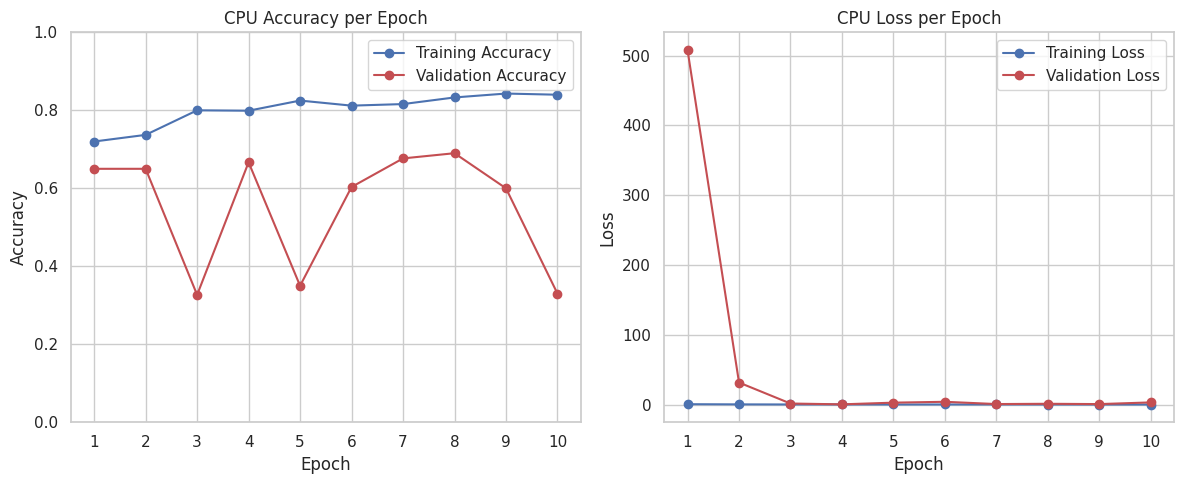

In [ ]:
plot_training_history(history, title_prefix="CPU")

- overfitting
- unstable generalisation (val_acc ~ 0.35 - 0.65)
- high val_loss (over 500)

## 3. TRAINING SPEED OPTIMISATION

### 3a. GPU

In [ ]:
test_gen = get_test_generator(test_df, normalize=False)

Found 2586 validated image filenames.


In [ ]:
# build a new model to make sure I'm not using a pre-trained one
model2 = build_model(model_name='ResNet50',
                input_size=224,
                weights=None, # no transfer learning
                trainable=True,
                add_dropout=False,
                learning_rate=0.001)
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 23,536,641 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
# model with no transfer learning, the same generators and
# number of epochs as before (for report purposes)

history_gpu, gpu_time = train_and_time(model2,
                                   small_train_generator, # 1000
                                   small_val_gen, # 300
                                   epochs=10)

print(f"\nGPU training time: {gpu_time/60:.2f} min")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.6526 - loss: 1.1126 - val_accuracy: 0.6500 - val_loss: 406.7725
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 302ms/step - accuracy: 0.7988 - loss: 0.4841 - val_accuracy: 0.6367 - val_loss: 2.6465
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 315ms/step - accuracy: 0.8192 - loss: 0.4177 - val_accuracy: 0.3500 - val_loss: 2.5474
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 303ms/step - accuracy: 0.8074 - loss: 0.4477 - val_accuracy: 0.3500 - val_loss: 2.0900
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 308ms/step - accuracy: 0.8410 - loss: 0.3932 - val_accuracy: 0.3467 - val_loss: 1.6770
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 311ms/step - accuracy: 0.8380 - loss: 0.3883 - val_accuracy: 0.3500 - val_loss: 2.3282
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 314ms/step - accuracy: 0.7836 - loss: 0.4947 - val_accuracy: 0.4433 - val_loss: 1.1307
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 312ms/step - accuracy: 0.7988 - loss: 0.4572 - val_accu

In [ ]:
final_gpu_train_acc = history_gpu.history['accuracy'][-1]
final_gpu_val_acc = history_gpu.history['val_accuracy'][-1]

print("3a. GPU (no transfer learning):")
print(f"  - Final train accuracy: {final_gpu_train_acc:.4f}\n  - Final validation accuracy: {final_gpu_val_acc:.4f}")

3a. GPU (no transfer learning):
  - Final train accuracy: 0.8420
  - Final validation accuracy: 0.6600


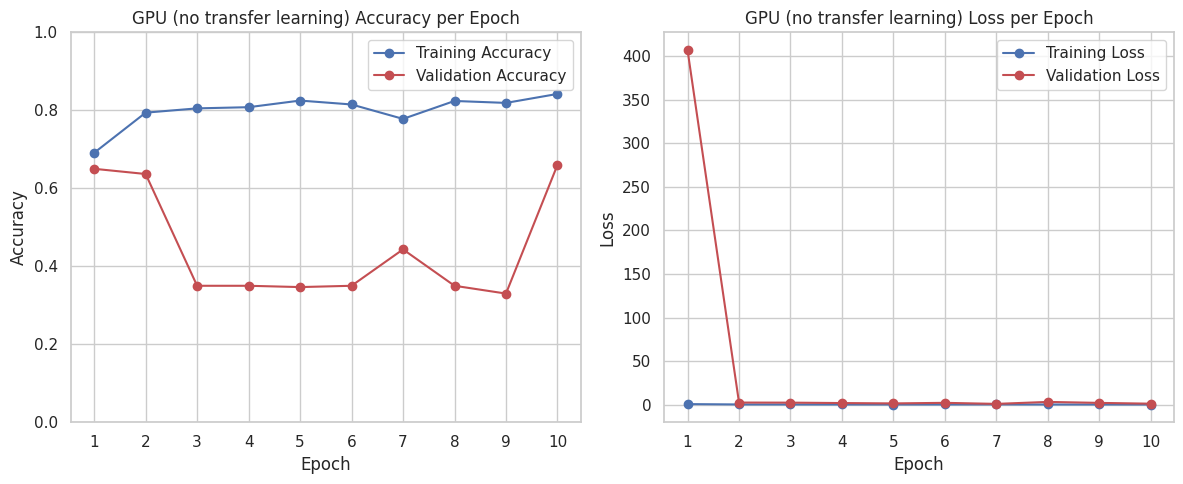

In [ ]:
plot_training_history(history_gpu, title_prefix="GPU (no transfer learning)")

- overfitting
- unstable generalisation (val_acc ~ 0.35 - 0.65)
- high val_loss (over 400)

### 3b. GPU + transfer learning

In [ ]:
# build a new model to make sure I'm not using a pre-trained one
modelTL = build_model(model_name='ResNet50',
                input_size=224,
                weights='imagenet', # using transfer learning
                trainable=False, # freeze base weights
                add_dropout=False,
                learning_rate=0.001)
modelTL.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
history_transfer, transfer_time = train_and_time(modelTL,
                                                 small_train_generator, # 1000
                                                 small_val_gen, # 300
                                                 epochs=10)

print(f"\n Transfer learning - training time: {transfer_time/60:.2f} min")

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 409ms/step - accuracy: 0.7263 - loss: 0.6086 - val_accuracy: 0.6600 - val_loss: 0.6941
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - accuracy: 0.8153 - loss: 0.4544 - val_accuracy: 0.6667 - val_loss: 0.7617
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.8218 - loss: 0.4372 - val_accuracy: 0.6633 - val_loss: 0.7576
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.8362 - loss: 0.3839 - val_accuracy: 0.6567 - val_loss: 0.8539
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.8441 - loss: 0.4090 - val_accuracy: 0.6767 - val_loss: 0.7175
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.8140 - loss: 0.4272 - val_accuracy: 0.6700 - val_loss: 0.7620
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.8518 - loss: 0.3694 - val_accuracy: 0.6600 - val_loss: 0.7133
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.8493 - loss: 0.3978 - val_accuracy: 0

In [ ]:
final_transfer_train_acc = history_transfer.history['accuracy'][-1]
final_transfer_val_acc = history_transfer.history['val_accuracy'][-1]
print("3b. GPU + transfer learning:")
print(f"  - Final train accuracy: {final_transfer_train_acc:.4f}\n  - Final validation accuracy: {final_transfer_val_acc:.4f}")

3b. GPU + transfer learning:
  - Final train accuracy: 0.8410
  - Final validation accuracy: 0.6667


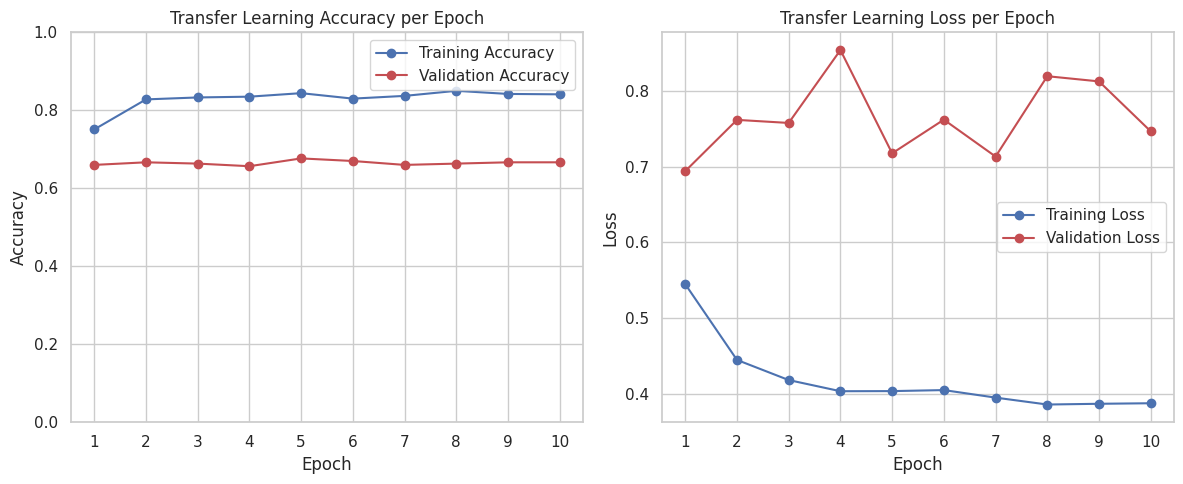

In [ ]:
plot_training_history(history_transfer, title_prefix="Transfer Learning")

- slight overfitting (there's still a gap between train_acc and val_acc)
- more stable generalisation (val_acc 0.65-0.68)

### CPU/GPU/GPU + transfer learning comparison

In [ ]:
print("2. CPU:")
print(f"  - Final train accuracy: 0.8400 \n  - Final validation accuracy: 0.3300")
print("3a. GPU (no transfer learning):")
print(f"  - Final train accuracy: {final_gpu_train_acc:.4f}\n  - Final validation accuracy: {final_gpu_val_acc:.4f}")
print("3b. GPU + transfer learning:")
print(f"  - Final train accuracy: {final_transfer_train_acc:.4f}\n  - Final validation accuracy: {final_transfer_val_acc:.4f}")

2. CPU:
  - Final train accuracy: 0.8400 
  - Final validation accuracy: 0.3300
3a. GPU (no transfer learning):
  - Final train accuracy: 0.8420
  - Final validation accuracy: 0.6600
3b. GPU + transfer learning:
  - Final train accuracy: 0.8410
  - Final validation accuracy: 0.6667


- **val_acc = 0.33** (CPU) - overfitting, model memorized the training data but performs poorly on new data.
- 3rd is slightly better than 2nd: val_acc is the highest (0.67), so the model generalizes better to unseen data.

In [ ]:
print(f"CPU (no transfer learning) training time: 83.64 min")
print(f"GPU (no transfer learning) training time: {gpu_time/60:.2f} min")
print(f"GPU + transfer learning training time: {transfer_time/60:.2f} min")

CPU (no transfer learning) training time: 83.64 min
GPU (no transfer learning) training time: 3.22 min
GPU + transfer learning training time: 1.01 min


***Due to the best overall score, I'm gonna use GPU + transfer learning from now on***

## 4. OPTIMALISATION

### 4d. Adding new data samples (using whole dataset from now on)

In [ ]:
train_gen0 = get_train_generator(train_df, normalize=False)
val_gen0 = get_val_generator(val_df, normalize=False)

Found 10661 validated image filenames belonging to 2 classes.
Found 1867 validated image filenames belonging to 2 classes.


In [ ]:
# build a new model to make sure I'm not using a pre-trained one
new_samples_model = build_model(model_name='ResNet50',
                input_size=224,
                weights='imagenet',
                trainable=False, # freeze base weights
                add_dropout=False,
                learning_rate=0.001)

new_samples_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
history_newSamples, new_samples_time = train_and_time(new_samples_model,
                                    train_gen0, # 10661
                                    val_gen0, # 1867
                                    epochs=10)

print(f"\n New samples - training time: {new_samples_time/60:.2f} min")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 82s 215ms/step - accuracy: 0.7938 - loss: 0.4803 - val_accuracy: 0.6776 - val_loss: 0.7050
Epoch 2/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 59s 176ms/step - accuracy: 0.8197 - loss: 0.4204 - val_accuracy: 0.6851 - val_loss: 0.7036
Epoch 3/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 55s 165ms/step - accuracy: 0.8280 - loss: 0.4037 - val_accuracy: 0.6947 - val_loss: 0.6520
Epoch 4/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 53s 157ms/step - accuracy: 0.8396 - loss: 0.3816 - val_accuracy: 0.6909 - val_loss: 0.7103
Epoch 5/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 53s 159ms/step - accuracy: 0.8433 - loss: 0.3825 - val_accuracy: 0.6958 - val_loss: 0.6108
Epoch 6/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 78s 147ms/step - accuracy: 0.8403 - loss: 0.3871 - val_accuracy: 0.6834 - val_loss: 0.7910
Epoch 7/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 51s 151ms/step - accuracy: 0.8352 - loss: 0.3899 - val_accuracy: 0.6963 - val_loss: 0.6730
Epoch 8/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 48s 144ms/step - accuracy: 0.8450 - loss: 0

In [ ]:
final_new_samples_train_acc = history_newSamples.history['accuracy'][-1]
final_new_samples_val_acc = history_newSamples.history['val_accuracy'][-1]
print("4d. Added new samples:")
print(f"  - Final train accuracy: {final_transfer_train_acc:.4f}\n  - Final validation accuracy: {final_transfer_val_acc:.4f}")

4d. Added new samples:
  - Final train accuracy: 0.8410
  - Final validation accuracy: 0.6667


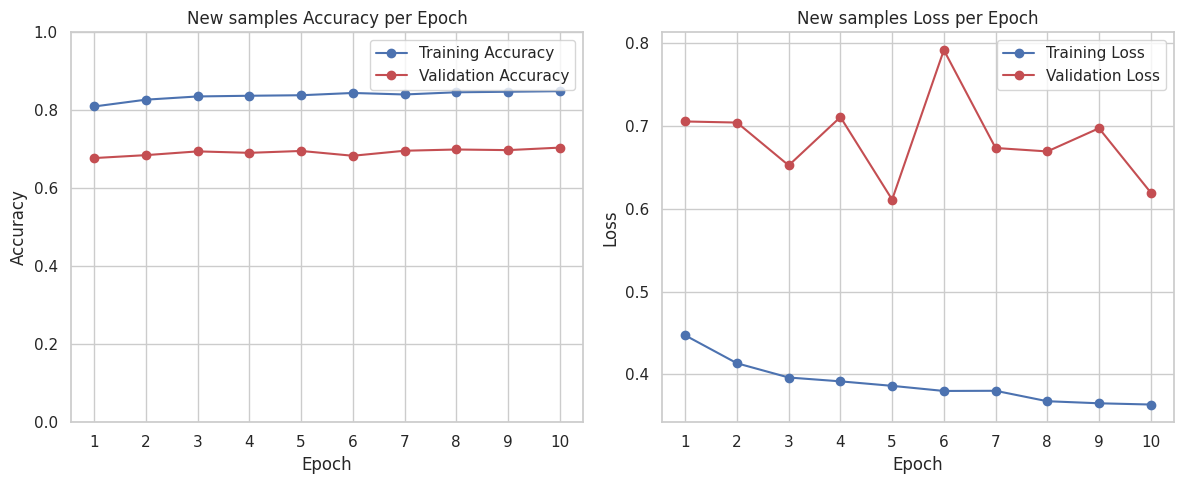

In [ ]:
plot_training_history(history_newSamples, title_prefix="New samples")

Adding new samples resulted in slightly better generalisation.

### 4a. Normalisation

In [ ]:
norm_train_gen = get_train_generator(train_df, normalize=True) # normalisation

norm_val_gen = get_val_generator(val_df, normalize=True) # normalisation

norm_test_gen = get_test_generator(test_df, normalize=True) # normalisation

print(norm_train_gen.class_indices)
print(norm_val_gen.class_indices)

Found 10661 validated image filenames belonging to 2 classes.
Found 1867 validated image filenames belonging to 2 classes.
Found 2586 validated image filenames.
{'all': 0, 'hem': 1}
{'all': 0, 'hem': 1}


In [ ]:
# build a new model to make sure I'm not using a pre-trained one
modelNorm = build_model(model_name='ResNet50',
                input_size=224,
                weights='imagenet',
                trainable=False,
                add_dropout=False,
                learning_rate=0.001)
modelNorm.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# training
history_transferNorm, transfer_time = train_and_time(modelNorm,
                                                     norm_train_gen, # 10166
                                                     norm_val_gen, # 1867
                                                     epochs=10)

print(f"\n Normalisation - training time: {transfer_time/60:.2f} min")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 80s 206ms/step - accuracy: 0.7686 - loss: 0.5080 - val_accuracy: 0.6652 - val_loss: 0.6566
Epoch 2/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 60s 180ms/step - accuracy: 0.8233 - loss: 0.4316 - val_accuracy: 0.6722 - val_loss: 0.7174
Epoch 3/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 60s 181ms/step - accuracy: 0.8299 - loss: 0.4065 - val_accuracy: 0.6840 - val_loss: 0.7136
Epoch 4/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 61s 181ms/step - accuracy: 0.8345 - loss: 0.3976 - val_accuracy: 0.6808 - val_loss: 0.7329
Epoch 5/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 58s 174ms/step - accuracy: 0.8267 - loss: 0.4032 - val_accuracy: 0.7022 - val_loss: 0.5994
Epoch 6/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 58s 174ms/step - accuracy: 0.8352 - loss: 0.3890 - val_accuracy: 0.6995 - val_loss: 0.6621
Epoch 7/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 61s 182ms/step - accuracy: 0.8336 - loss: 0.3875 - val_accuracy: 0.6813 - val_loss: 0.6325
Epoch 8/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 58s 175ms/step - accuracy: 0.8425 - loss: 0

In [ ]:
final_transferNorm_train_acc = history_transferNorm.history['accuracy'][-1]
final_transferNorm_val_acc = history_transferNorm.history['val_accuracy'][-1]
print("4a. Normalisation:")
print(f"  - Final train accuracy: {final_transferNorm_train_acc:.4f}\n  - Final validation accuracy: {final_transferNorm_val_acc:.4f}")

4a. Normalisation:
  - Final train accuracy: 0.8427
  - Final validation accuracy: 0.6952


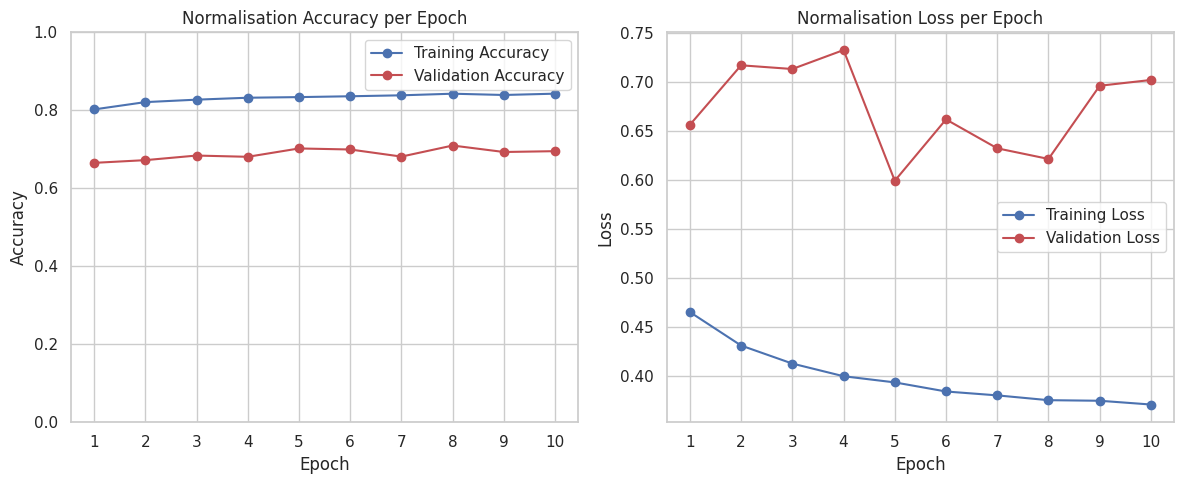

In [ ]:
plot_training_history(history_transferNorm, title_prefix="Normalisation")

### 4b. Augmentation
Due to the fact that the train set contains 2x more cancer cells than healthy cells:

- > **ALL:** 7272 (cancer cells)
- > **HEM:** 3389 (healthy cells)

I used augmentation only for 'HEM' samples so that the model isn't biased towards the dominating class 'ALL'




Generating missing HEM samples:

In [ ]:
num_augmented = 3883  # missing HEM samples
image_size = (224, 224)
output_folder = "/content/leukemia_dataset/C-NMC_Leukemia/training_data/augmented_hem"

# directory for saving
os.makedirs(output_folder, exist_ok=True)

# copy all hem samples
hem_df = train_df[train_df['label'] == 'hem'].copy()

aug_datagen = ImageDataGenerator(
        rotation_range=25, # small rotations to show cells in different angles (without distorting key features)
        width_shift_range=0.05,  # helps generalize for cells not perfectly centered
        height_shift_range=0.05, # helps generalize for cells not perfectly centered
        zoom_range=0.1,       # small zoom to handle different cell sizes
        fill_mode='nearest' # use the nearest pixel values to fill in gaps created by modifying the image
)

# temp generator
temp_gen = aug_datagen.flow_from_dataframe(
        dataframe=hem_df,
        x_col='filename',
        target_size=image_size,
        class_mode=None,
        batch_size=1, # 1 image at a time
        shuffle=True,
        save_to_dir=output_folder,
        save_prefix='aug_',
        save_format='jpeg' # smaller file size compared to .bmp, it’s a lossy format but visual difference is negligible
)

print("\nAugmenting HEM images...")
for i in range(num_augmented):
        next(temp_gen) # every next() saves 1 image to dir

print("\nAugmentation done.")

# all generated hem images
aug_filenames = [os.path.join(output_folder, f) for f in os.listdir(output_folder) if f.endswith('.jpeg')]
aug_labels = ['hem'] * len(aug_filenames)
aug_df = pd.DataFrame({'filename': aug_filenames, 'label': aug_labels})

# concat with existing train_df
final_train_df = pd.concat([train_df, aug_df], ignore_index=True)

print(f"\nUpdated train_df has: {len(final_train_df)} \n(ALL samples: {sum(final_train_df['label']=='all')}, HEM samples: {sum(final_train_df['label']=='hem')})")

Found 3389 validated image filenames.

Augmenting HEM images...

Augmentation done.

Updated train_df has: 14544 
(ALL samples: 7272, HEM samples: 7272)


4b.1: augmentation without normalisation (even though we use transfer learning) - report purposes

In [ ]:
aug_train_gen1 = get_train_generator(final_train_df, normalize=False)
aug_val_generator1 = get_val_generator(val_df, normalize=False)

Found 14544 validated image filenames belonging to 2 classes.
Found 1867 validated image filenames belonging to 2 classes.


In [ ]:
# build a new model to make sure I'm not using a pre-trained one
modelAug1 = build_model(model_name='ResNet50',
                input_size=224,
                weights='imagenet', # transfer learning
                trainable=False,
                add_dropout=False,
                learning_rate=0.001)

modelAug1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# training model
history_TLAug1, transfer_time = train_and_time(modelAug1,
                                               aug_train_gen1, # 14544
                                               aug_val_generator1, # 1867
                                               epochs=10)

print(f"\nAugmentation alone - training time: {transfer_time/60:.2f} min")

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


455/455 ━━━━━━━━━━━━━━━━━━━━ 84s 155ms/step - accuracy: 0.8203 - loss: 0.3947 - val_accuracy: 0.6722 - val_loss: 0.6346
Epoch 2/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 55s 120ms/step - accuracy: 0.8650 - loss: 0.3182 - val_accuracy: 0.6883 - val_loss: 0.7090
Epoch 3/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 53s 116ms/step - accuracy: 0.8771 - loss: 0.3015 - val_accuracy: 0.6909 - val_loss: 0.6516
Epoch 4/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - accuracy: 0.8729 - loss: 0.2992 - val_accuracy: 0.6883 - val_loss: 0.7672
Epoch 5/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - accuracy: 0.8885 - loss: 0.2775 - val_accuracy: 0.7033 - val_loss: 0.5883
Epoch 6/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 49s 107ms/step - accuracy: 0.8837 - loss: 0.2772 - val_accuracy: 0.6899 - val_loss: 0.7189
Epoch 7/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - accuracy: 0.8788 - loss: 0.2878 - val_accuracy: 0.7027 - val_loss: 0.6627
Epoch 8/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 83s 110ms/step - accuracy: 0.8894 - loss: 0.2713 - val

In [ ]:
final_TLAug_train_acc = history_TLAug1.history['accuracy'][-1]
final_TLAug_val_acc = history_TLAug1.history['val_accuracy'][-1]
print("4b.1. Augmentation alone:")
print(f"  - Final train accuracy: {final_TLAug_train_acc:.4f}\n  - Final validation accuracy: {final_TLAug_val_acc:.4f}")

4b.1. Augmentation alone:
  - Final train accuracy: 0.8914
  - Final validation accuracy: 0.6990


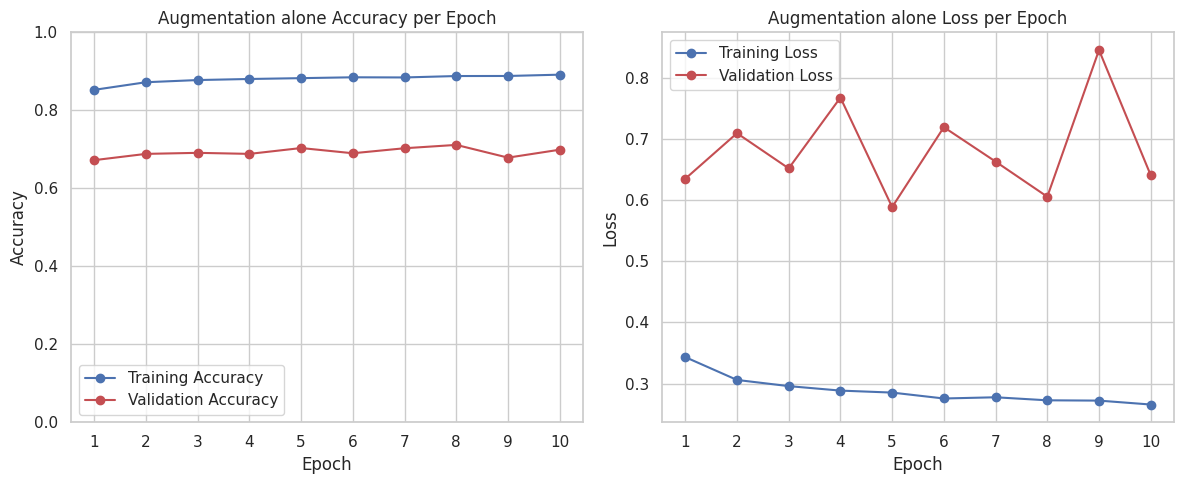

In [ ]:
plot_training_history(history_TLAug1, title_prefix="Augmentation alone")

4b.2: augmentation + normalisation

In [ ]:
aug_train_gen2 = get_train_generator(final_train_df, normalize=True)
aug_val_generator2 = get_val_generator(val_df, normalize=True)

Found 14544 validated image filenames belonging to 2 classes.
Found 1867 validated image filenames belonging to 2 classes.


In [ ]:
# build a new model to make sure I'm not using a pre-trained one
modelAug2 = build_model(model_name='ResNet50',
                input_size=224,
                weights='imagenet', # transfer learning
                trainable=False, # freeze base weights
                add_dropout=False,
                learning_rate=0.001)

modelAug2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# training model
history_TLAug2, transfer_time = train_and_time(modelAug2,
                                               aug_train_gen2, # 14544
                                               aug_val_generator2, # 1867
                                               epochs=10)

print(f"\n Augmentation + normalisation - training time: {transfer_time/60:.2f} min")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 80s 141ms/step - accuracy: 0.8027 - loss: 0.4271 - val_accuracy: 0.6583 - val_loss: 0.6589
Epoch 2/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 63s 138ms/step - accuracy: 0.8642 - loss: 0.3263 - val_accuracy: 0.6802 - val_loss: 0.6629
Epoch 3/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 60s 132ms/step - accuracy: 0.8715 - loss: 0.3052 - val_accuracy: 0.6861 - val_loss: 0.6185
Epoch 4/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 60s 131ms/step - accuracy: 0.8720 - loss: 0.3029 - val_accuracy: 0.6797 - val_loss: 0.7299
Epoch 5/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 60s 133ms/step - accuracy: 0.8733 - loss: 0.2967 - val_accuracy: 0.6947 - val_loss: 0.6392
Epoch 6/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 58s 128ms/step - accuracy: 0.8812 - loss: 0.2781 - val_accuracy: 0.6829 - val_loss: 0.6226
Epoch 7/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 84s 132ms/step - accuracy: 0.8811 - loss: 0.2856 - val_accuracy: 0.7049 - val_loss: 0.5798
Epoch 8/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 59s 129ms/step - accuracy: 0.8840 - loss: 0

In [ ]:
final_TLAug2_train_acc = history_TLAug2.history['accuracy'][-1]
final_TLAug2_val_acc = history_TLAug2.history['val_accuracy'][-1]
print("4b.2. Augmentation + normalisation")
print(f"  - Final train accuracy: {final_TLAug2_train_acc:.4f}\n  - Final validation accuracy: {final_TLAug2_val_acc:.4f}")

4b.2. Augmentation + normalisation
  - Final train accuracy: 0.8862
  - Final validation accuracy: 0.6883


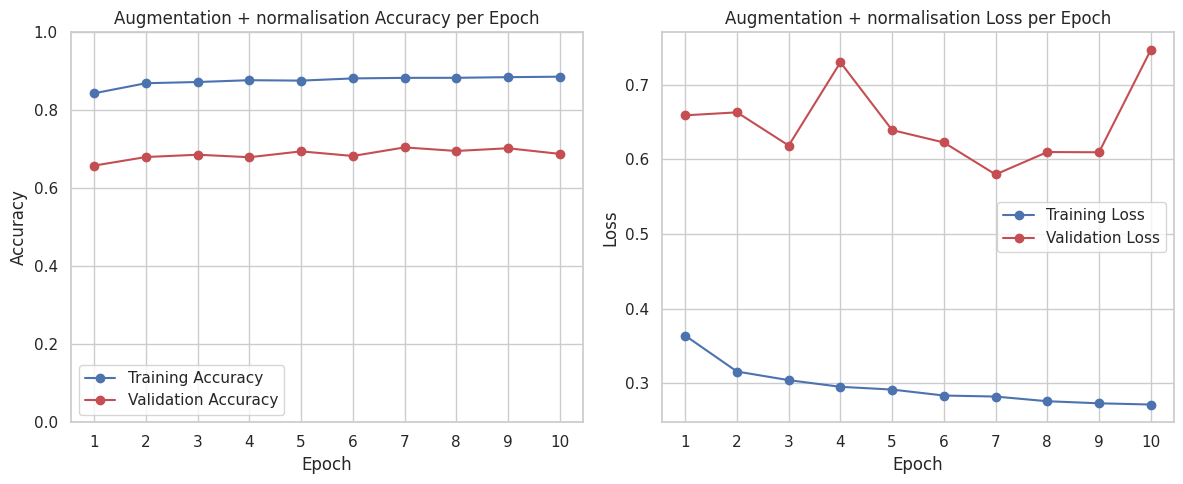

In [ ]:
plot_training_history(history_TLAug2, title_prefix="Augmentation + normalisation")

***Model performs best when both data normalization and augmentation are applied (even though val_acc is slightly lower, val_loss is more stable with aug + norm). These techniques will be used in further training.***

### 4c. Dropout

In [ ]:
dropout_train_gen = get_train_generator(final_train_df, normalize=True) # with augmentation + normalisation as mentioned above
dropout_val_gen = get_val_generator(val_df, normalize=True) # -||-

Found 14544 validated image filenames belonging to 2 classes.
Found 1867 validated image filenames belonging to 2 classes.


In [ ]:
# adding dropout
model_dropout = build_model(model_name='ResNet50',
                input_size=224,
                weights='imagenet', # transfer learning
                trainable=False, # freeze base weights
                add_dropout=True, # include Dropout layer
                dropout_rate=0.3, # dropout rate since Dropout is included
                learning_rate=0.001)

model_dropout.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# early stopping to stop if validation accuracy isn't improving after 3 epochs
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history_with_dropout, transfer_time = train_and_time(model_dropout,
                                                     dropout_train_gen, # 14544
                                                     dropout_val_gen, # 1867
                                                     epochs=10,
                                                     callbacks=[early_stop])

print(f"\n Dropout (0.3) - training time: {transfer_time/60:.2f} min")

# show best val accuracy
best_val_acc = max(history_with_dropout.history['val_accuracy'])
print(f"Best validation accuracy with dropout: {best_val_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 92s 176ms/step - accuracy: 0.7849 - loss: 0.4519 - val_accuracy: 0.6685 - val_loss: 0.8044
Epoch 2/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 130s 159ms/step - accuracy: 0.8552 - loss: 0.3424 - val_accuracy: 0.6765 - val_loss: 0.6586
Epoch 3/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 83s 161ms/step - accuracy: 0.8623 - loss: 0.3309 - val_accuracy: 0.6754 - val_loss: 0.7792
Epoch 4/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 73s 160ms/step - accuracy: 0.8636 - loss: 0.3212 - val_accuracy: 0.6904 - val_loss: 0.6541
Epoch 5/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 72s 159ms/step - accuracy: 0.8685 - loss: 0.3163 - val_accuracy: 0.6942 - val_loss: 0.6195
Epoch 6/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 73s 160ms/step - accuracy: 0.8714 - loss: 0.3039 - val_accuracy: 0.6818 - val_loss: 0.7390
Epoch 7/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 72s 159ms/step - accuracy: 0.8752 - loss: 0.3040 - val_accuracy: 0.7006 - val_loss: 0.5729
Epoch 8/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 72s 159ms/step - accuracy: 0.8694 - loss: 

In [ ]:
final_dropout_train_acc = history_with_dropout.history['accuracy'][-1]
final_dropout_val_acc = history_with_dropout.history['val_accuracy'][-1]
print("4c. Dropout")
print(f"  - Final train accuracy: {final_dropout_train_acc:.4f}\n  - Final validation accuracy: {final_dropout_val_acc:.4f}")

4c. Dropout
  - Final train accuracy: 0.8711
  - Final validation accuracy: 0.6904


### 4e. Different input sizes (96x96, 160x160, 224x224)

In [ ]:
sizes = [96, 160, 224]
results = {}

for size in sizes:
    print(f"\nTraining with input size: {size}x{size}")

    # building model
    modelIS = build_model(model_name='ResNet50',
                input_size=size,
                weights='imagenet', # transfer learning
                trainable=False, # freeze base weights
                add_dropout=True, # include Dropout layer
                dropout_rate=0.3, # dropout rate since Dropout is included
                learning_rate=0.001)

    # generators
    IS_train_gen = get_train_generator(final_train_df, normalize=True, image_size=size)
    IS_val_gen = get_val_generator(val_df, normalize=True, image_size=size)

    # training
    history_modelIS, training_time = train_and_time(modelIS,
                                                    IS_train_gen, # 14544
                                                    IS_val_gen, # 1867
                                                    epochs=10)

    print(f"Training time for {size}x{size}: {training_time/60:.2f} min")

    results[size] = {
        "history": history_modelIS,
        "training_time": training_time
    }


Training with input size: 96x96
Found 14544 validated image filenames belonging to 2 classes.
Found 1867 validated image filenames belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


455/455 ━━━━━━━━━━━━━━━━━━━━ 63s 116ms/step - accuracy: 0.7746 - loss: 0.4670 - val_accuracy: 0.6802 - val_loss: 0.7386
Epoch 2/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 42s 92ms/step - accuracy: 0.8496 - loss: 0.3546 - val_accuracy: 0.6818 - val_loss: 0.6393
Epoch 3/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 44s 96ms/step - accuracy: 0.8584 - loss: 0.3325 - val_accuracy: 0.6829 - val_loss: 0.7063
Epoch 4/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 44s 96ms/step - accuracy: 0.8649 - loss: 0.3280 - val_accuracy: 0.6888 - val_loss: 0.6716
Epoch 5/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 50s 110ms/step - accuracy: 0.8579 - loss: 0.3342 - val_accuracy: 0.6915 - val_loss: 0.6485
Epoch 6/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 43s 95ms/step - accuracy: 0.8648 - loss: 0.3249 - val_accuracy: 0.6813 - val_loss: 0.7843
Epoch 7/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 45s 100ms/step - accuracy: 0.8605 - loss: 0.3232 - val_accuracy: 0.6877 - val_loss: 0.7232
Epoch 8/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 47s 102ms/step - accuracy: 0.8710 - loss: 0.3035 - val_acc

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 77s 140ms/step - accuracy: 0.7907 - loss: 0.4560 - val_accuracy: 0.6679 - val_loss: 0.8161
Epoch 2/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 52s 113ms/step - accuracy: 0.8524 - loss: 0.3507 - val_accuracy: 0.6776 - val_loss: 0.7452
Epoch 3/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 54s 118ms/step - accuracy: 0.8602 - loss: 0.3371 - val_accuracy: 0.6792 - val_loss: 0.7791
Epoch 4/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 54s 118ms/step - accuracy: 0.8614 - loss: 0.3346 - val_accuracy: 0.6845 - val_loss: 0.6624
Epoch 5/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 56s 123ms/step - accuracy: 0.8610 - loss: 0.3285 - val_accuracy: 0.6802 - val_loss: 0.7055
Epoch 6/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 54s 119ms/step - accuracy: 0.8636 - loss: 0.3197 - val_accuracy: 0.6743 - val_loss: 0.6634
Epoch 7/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 55s 120ms/step - accuracy: 0.8686 - loss: 0.3174 - val_accuracy: 0.6824 - val_loss: 0.6668
Epoch 8/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 55s 121ms/step - accuracy: 0.8680 - loss: 0

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 86s 163ms/step - accuracy: 0.7838 - loss: 0.4476 - val_accuracy: 0.6636 - val_loss: 0.7718
Epoch 2/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 68s 149ms/step - accuracy: 0.8610 - loss: 0.3286 - val_accuracy: 0.6776 - val_loss: 0.6250
Epoch 3/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 66s 145ms/step - accuracy: 0.8631 - loss: 0.3298 - val_accuracy: 0.6674 - val_loss: 0.9119
Epoch 4/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 66s 146ms/step - accuracy: 0.8693 - loss: 0.3170 - val_accuracy: 0.6936 - val_loss: 0.6246
Epoch 5/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 70s 154ms/step - accuracy: 0.8607 - loss: 0.3245 - val_accuracy: 0.6909 - val_loss: 0.6297
Epoch 6/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 69s 151ms/step - accuracy: 0.8713 - loss: 0.3123 - val_accuracy: 0.6942 - val_loss: 0.6544
Epoch 7/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 67s 147ms/step - accuracy: 0.8717 - loss: 0.3073 - val_accuracy: 0.6824 - val_loss: 0.7595
Epoch 8/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 66s 146ms/step - accuracy: 0.8760 - loss: 0

In [ ]:
for size, result in results.items():
    train_acc = result['history'].history['accuracy'][-1]
    val_acc = result['history'].history['val_accuracy'][-1]
    print(f"  - Input size {size}x{size}:")
    print(f"      Final train accuracy:      {train_acc:.4f}")
    print(f"      Final validation accuracy: {val_acc:.4f}\n")

  - Input size 96x96:
      Final train accuracy:      0.8656
      Final validation accuracy: 0.6845

  - Input size 160x160:
      Final train accuracy:      0.8675
      Final validation accuracy: 0.6872

  - Input size 224x224:
      Final train accuracy:      0.8698
      Final validation accuracy: 0.6824



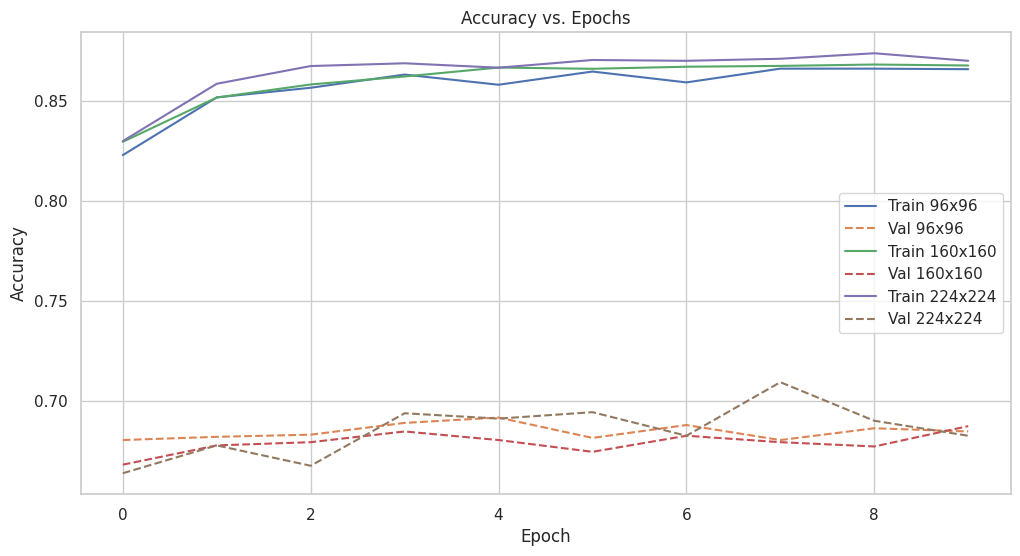

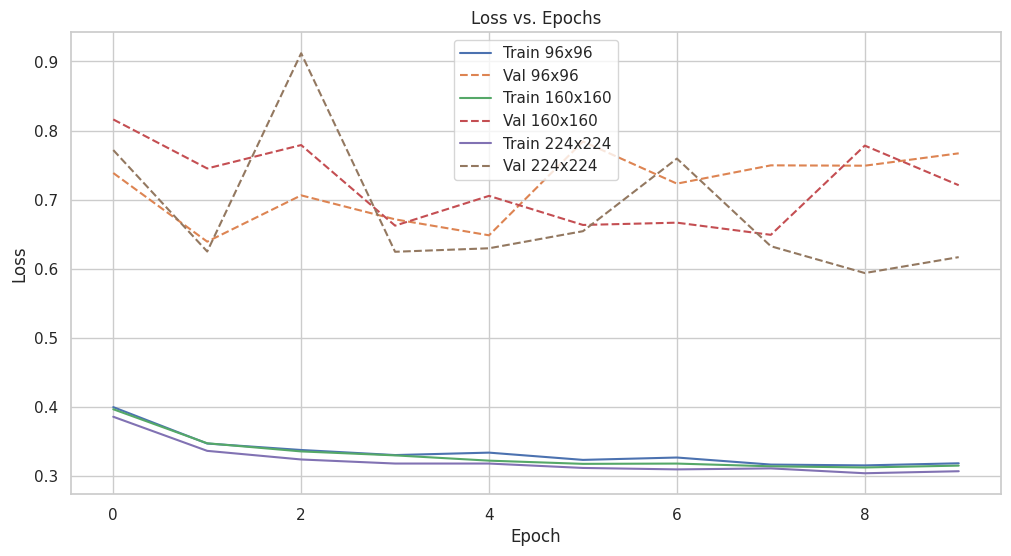

In [ ]:
def plot_histories(histories, metric='accuracy'):
    plt.figure(figsize=(12, 6))
    for size, history in histories.items():
        plt.plot(history.history[metric], label=f'Train {size}x{size}')
        plt.plot(history.history[f'val_{metric}'], linestyle='--', label=f'Val {size}x{size}')
    plt.title(f'{metric.capitalize()} vs. Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

# Accuracy
plot_histories({size: r["history"] for size, r in results.items()}, metric='accuracy')

# Loss
plot_histories({size: r["history"] for size, r in results.items()}, metric='loss')

val_acc for 96x96 and 160x160 appears most stable, however val_loss curve for 160x160 indicates better generalisation and more consistent performance

***using 160x160 further on due to being a balanced choice between accuracy/loss and speed***

## 4f. Different batch sizes (32, 64, 128)

batch_size=32 has already been tested

In [ ]:
train_gen_BS64 = get_train_generator(final_train_df, normalize=True, batch_size=64, image_size=160) # using 160x160 as mentioned above
val_gen_BS64 = get_val_generator(val_df, normalize=True, batch_size=64, image_size=160) # -||-

Found 14544 validated image filenames belonging to 2 classes.
Found 1867 validated image filenames belonging to 2 classes.


In [ ]:
# build model
modelBS64 = build_model(model_name='ResNet50',
                input_size=160, # using 160 as mentioned above
                weights='imagenet', # transfer learning
                trainable=False, # freeze base weights
                add_dropout=True, # include Dropout layer
                dropout_rate=0.3, # dropout rate since Dropout is added
                learning_rate=0.001)

# start timer + training
history_modelBS64, training_time = train_and_time(modelBS64,
                                                  train_gen_BS64,
                                                  val_gen_BS64,
                                                  epochs=10)

print(f"Training time for batch_size=64: {training_time/60:.2f} min")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 88s 315ms/step - accuracy: 0.7595 - loss: 0.4906 - val_accuracy: 0.6663 - val_loss: 0.7064
Epoch 2/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 55s 241ms/step - accuracy: 0.8501 - loss: 0.3583 - val_accuracy: 0.6851 - val_loss: 0.6794
Epoch 3/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 56s 246ms/step - accuracy: 0.8575 - loss: 0.3386 - val_accuracy: 0.6797 - val_loss: 0.7175
Epoch 4/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 53s 232ms/step - accuracy: 0.8624 - loss: 0.3318 - val_accuracy: 0.6845 - val_loss: 0.6978
Epoch 5/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 56s 245ms/step - accuracy: 0.8574 - loss: 0.3327 - val_accuracy: 0.6760 - val_loss: 0.7911
Epoch 6/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 58s 254ms/step - accuracy: 0.8652 - loss: 0.3226 - val_accuracy: 0.6861 - val_loss: 0.6578
Epoch 7/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 54s 236ms/step - accuracy: 0.8608 - loss: 0.3292 - val_accuracy: 0.6813 - val_loss: 0.6354
Epoch 8/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 52s 226ms/step - accuracy: 0.8643 - loss: 0

In [ ]:
train_gen_BS128 = get_train_generator(final_train_df, normalize=True, batch_size=128, image_size=160)
val_gen_BS128 = get_val_generator(val_df, normalize=True, batch_size=128, image_size=160)

Found 14544 validated image filenames belonging to 2 classes.
Found 1867 validated image filenames belonging to 2 classes.


In [ ]:
# build model
modelBS128 = build_model(model_name='ResNet50',
                input_size=160,
                weights='imagenet', # transfer learning
                trainable=False, # freeze base weights
                add_dropout=True, # include Dropout layer
                dropout_rate=0.3, # dropout rate since Dropout is included
                learning_rate=0.001)

# start timer + training
history_modelBS128, training_time = train_and_time(modelBS128,
                                                   train_gen_BS128,
                                                   val_gen_BS128,
                                                   epochs=10)

print(f"Training time for batch_size=128: {training_time/60:.2f} min")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 94s 671ms/step - accuracy: 0.7129 - loss: 0.5624 - val_accuracy: 0.6652 - val_loss: 0.7653
Epoch 2/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 61s 538ms/step - accuracy: 0.8369 - loss: 0.3784 - val_accuracy: 0.6679 - val_loss: 0.7186
Epoch 3/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 61s 536ms/step - accuracy: 0.8529 - loss: 0.3489 - val_accuracy: 0.6749 - val_loss: 0.7251
Epoch 4/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 63s 556ms/step - accuracy: 0.8555 - loss: 0.3425 - val_accuracy: 0.6792 - val_loss: 0.6938
Epoch 5/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 63s 552ms/step - accuracy: 0.8645 - loss: 0.3302 - val_accuracy: 0.6808 - val_loss: 0.6834
Epoch 6/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 63s 557ms/step - accuracy: 0.8618 - loss: 0.3291 - val_accuracy: 0.6754 - val_loss: 0.7477
Epoch 7/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 64s 559ms/step - accuracy: 0.8663 - loss: 0.3282 - val_accuracy: 0.6749 - val_loss: 0.6814
Epoch 8/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 66s 576ms/step - accuracy: 0.8690 - loss: 0

In [ ]:
# compare results
batchsize_results = {
    64: history_modelBS64,
    128: history_modelBS128
}

print("4b. Batch Size Comparison:")
for bs, history in batchsize_results.items():
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]
    print(f"  - Batch size {bs}:")
    print(f"      Final train accuracy:      {train_acc:.4f}")
    print(f"      Final validation accuracy: {val_acc:.4f}\n")

4b. Batch Size Comparison:
  - Batch size 64:
      Final train accuracy:      0.8698
      Final validation accuracy: 0.6797

  - Batch size 128:
      Final train accuracy:      0.8639
      Final validation accuracy: 0.6754



## Testing different models

In [ ]:
train_gen4g = get_train_generator(final_train_df, normalize=True, batch_size=32, image_size=160)
val_gen_4g = get_val_generator(val_df, normalize=True, batch_size=32, image_size=160)

Found 14544 validated image filenames belonging to 2 classes.
Found 1867 validated image filenames belonging to 2 classes.



TRAINING INCEPTIONV3...
Epoch 1/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 86s 155ms/step - accuracy: 0.7185 - loss: 12.2330 - val_accuracy: 0.6588 - val_loss: 6.7199
Epoch 2/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 61s 135ms/step - accuracy: 0.7862 - loss: 5.0958 - val_accuracy: 0.6904 - val_loss: 4.2964
Epoch 3/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 56s 122ms/step - accuracy: 0.7842 - loss: 3.6085 - val_accuracy: 0.6556 - val_loss: 9.7471
Epoch 4/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 58s 127ms/step - accuracy: 0.7927 - loss: 2.4304 - val_accuracy: 0.6947 - val_loss: 2.8867
Epoch 5/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 56s 123ms/step - accuracy: 0.7914 - loss: 2.1699 - val_accuracy: 0.6818 - val_loss: 6.8201
Epoch 6/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 59s 129ms/step - accuracy: 0.7957 - loss: 1.9680 - val_accuracy: 0.6604 - val_loss: 8.3780
Epoch 7/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 80s 124ms/step - accuracy: 0.7936 - loss: 2.4270 - val_accuracy: 0.7134 - val_loss: 2.6437
Epoch 8/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 58s 127ms/step - 

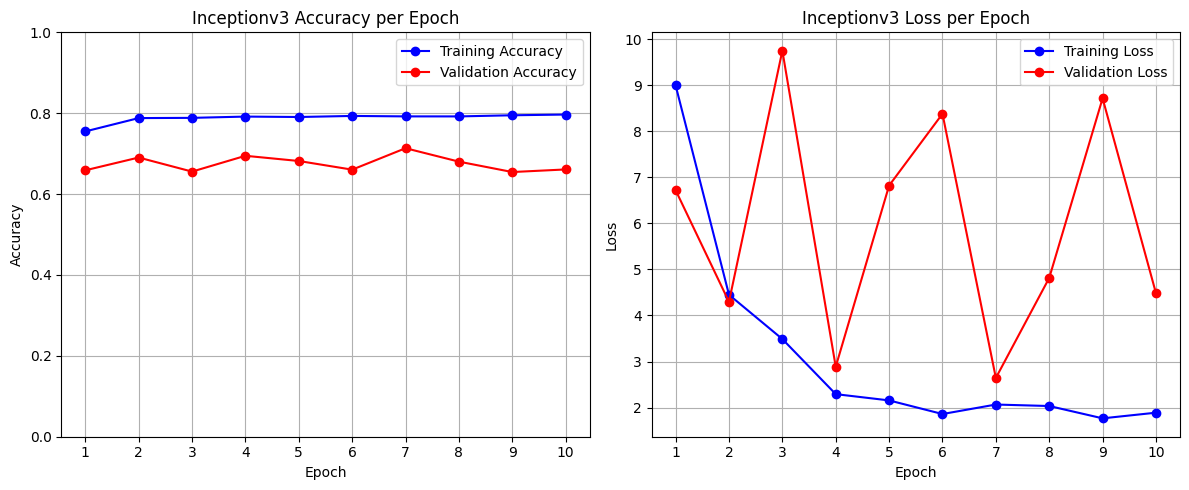


TRAINING RESNET101...
Epoch 1/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 96s 166ms/step - accuracy: 0.7746 - loss: 0.4971 - val_accuracy: 0.6867 - val_loss: 0.6322
Epoch 2/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 64s 140ms/step - accuracy: 0.8471 - loss: 0.3558 - val_accuracy: 0.6738 - val_loss: 0.7214
Epoch 3/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 62s 136ms/step - accuracy: 0.8524 - loss: 0.3467 - val_accuracy: 0.6845 - val_loss: 0.6353
Epoch 4/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 62s 136ms/step - accuracy: 0.8548 - loss: 0.3421 - val_accuracy: 0.6776 - val_loss: 0.8092
Epoch 5/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 61s 134ms/step - accuracy: 0.8579 - loss: 0.3379 - val_accuracy: 0.6695 - val_loss: 0.7961
Epoch 6/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 61s 133ms/step - accuracy: 0.8680 - loss: 0.3296 - val_accuracy: 0.6786 - val_loss: 0.8086
Epoch 7/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 60s 132ms/step - accuracy: 0.8663 - loss: 0.3207 - val_accuracy: 0.6802 - val_loss: 0.7357
Epoch 8/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 62s 135ms/step - acc

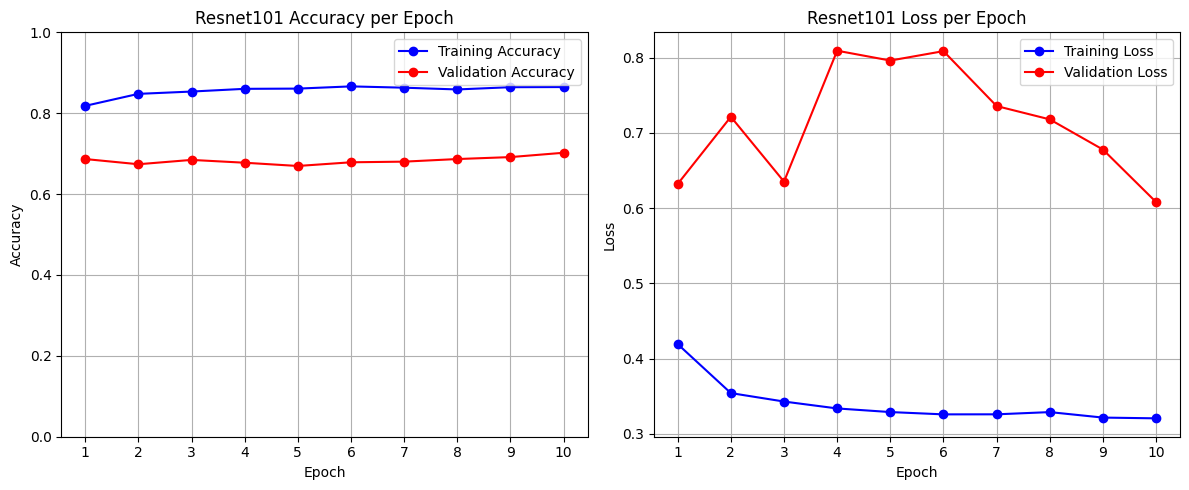


TRAINING DENSENET121...
Epoch 1/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 104s 178ms/step - accuracy: 0.6502 - loss: 2.7887 - val_accuracy: 0.6877 - val_loss: 1.1346
Epoch 2/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 57s 124ms/step - accuracy: 0.7898 - loss: 0.5721 - val_accuracy: 0.6765 - val_loss: 1.1032
Epoch 3/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 58s 126ms/step - accuracy: 0.8169 - loss: 0.4366 - val_accuracy: 0.6893 - val_loss: 0.7195
Epoch 4/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 56s 123ms/step - accuracy: 0.8179 - loss: 0.4185 - val_accuracy: 0.6926 - val_loss: 0.7659
Epoch 5/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 58s 128ms/step - accuracy: 0.8176 - loss: 0.4237 - val_accuracy: 0.6883 - val_loss: 0.7367
Epoch 6/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 57s 124ms/step - accuracy: 0.8324 - loss: 0.3936 - val_accuracy: 0.6695 - val_loss: 1.1383
Epoch 7/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 57s 125ms/step - accuracy: 0.8269 - loss: 0.4073 - val_accuracy: 0.6920 - val_loss: 0.8560
Epoch 8/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 56s 123ms/step - 

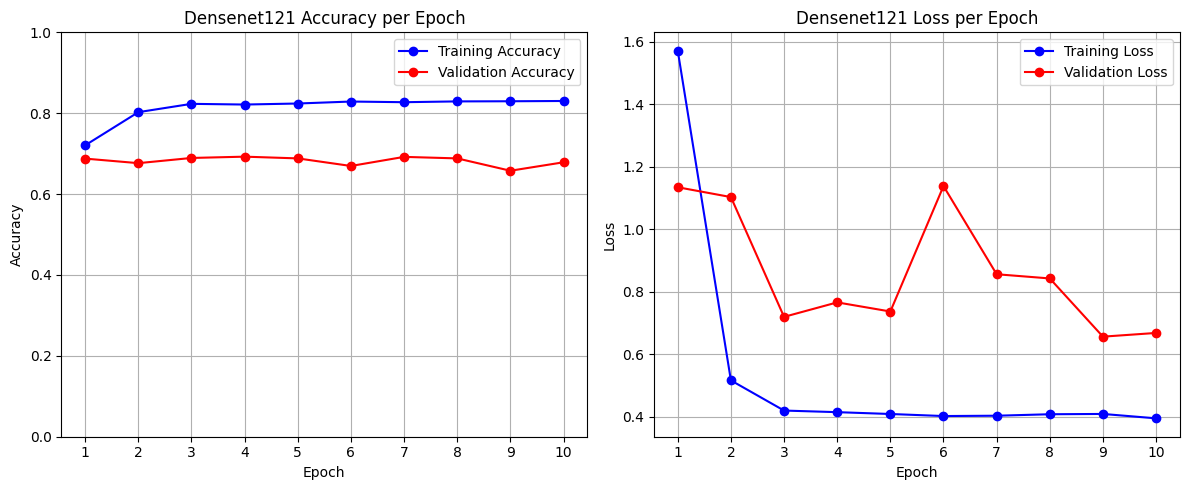


TRAINING EFFICIENTNETB0...
Epoch 1/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 96s 162ms/step - accuracy: 0.7180 - loss: 0.5676 - val_accuracy: 0.6770 - val_loss: 0.8439
Epoch 2/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 55s 121ms/step - accuracy: 0.8147 - loss: 0.4140 - val_accuracy: 0.6786 - val_loss: 0.8201
Epoch 3/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 56s 122ms/step - accuracy: 0.8123 - loss: 0.4190 - val_accuracy: 0.6781 - val_loss: 0.8245
Epoch 4/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 55s 120ms/step - accuracy: 0.8190 - loss: 0.4063 - val_accuracy: 0.6792 - val_loss: 0.7686
Epoch 5/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 57s 126ms/step - accuracy: 0.8241 - loss: 0.3987 - val_accuracy: 0.6786 - val_loss: 0.7736
Epoch 6/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 58s 128ms/step - accuracy: 0.8203 - loss: 0.3986 - val_accuracy: 0.6727 - val_loss: 0.7925
Epoch 7/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 82s 127ms/step - accuracy: 0.8244 - loss: 0.3928 - val_accuracy: 0.6802 - val_loss: 0.7558
Epoch 8/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 55s 120ms/step 

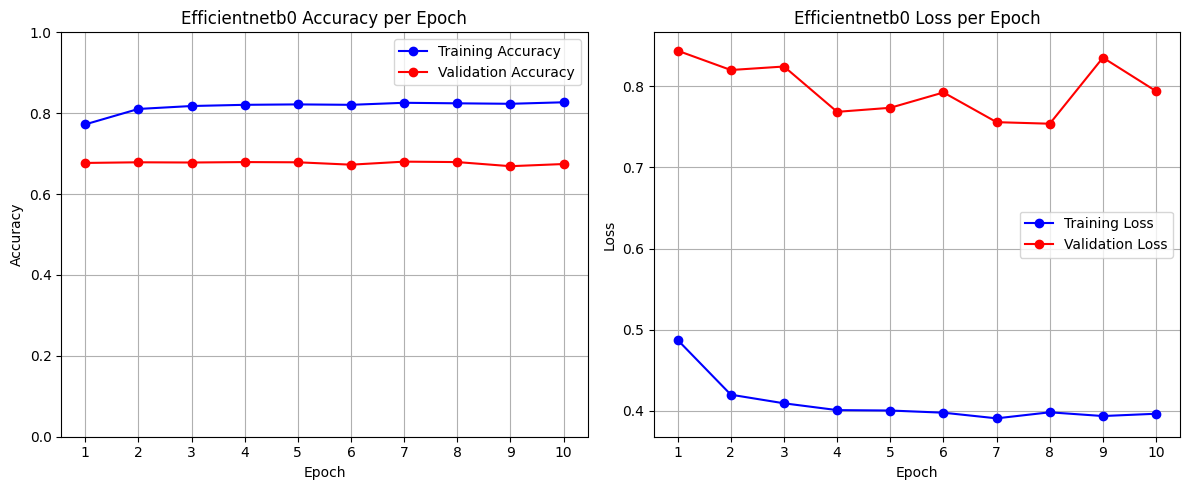


------ Summary of Results ------
Architecture         Training Time (min)  Train Accuracy       Val Accuracy        
--------------------------------------------------------------------------------
InceptionV3          10.49                0.7967               0.6610              
ResNet101            10.75                0.8647               0.7022              
DenseNet121          10.67                0.8302               0.6786              
EfficientNetB0       10.39                0.8270               0.6743              


In [ ]:
# train and evaluate each architecture separately
architectures = ["InceptionV3", "ResNet101", "DenseNet121", "EfficientNetB0"]
results = {"training_time": {},
           "train_accuracy": {},
           "val_accuracy": {}}

for arch in architectures:
    print(f"\nTRAINING {arch.upper()}...")

    # building model
    modelArch = build_model(model_name=arch,
                input_size=160,
                weights='imagenet', # transfer learning
                trainable=False, # freeze base weights
                add_dropout=True, # include Dropout layer
                dropout_rate=0.3, # dropout rate since Dropout is included
                learning_rate=0.001)

    # training model
    historyArch, training_time = train_and_time(modelArch,
                                                train_gen4g, # 14544
                                                val_gen_4g, # 1867
                                                epochs=10)

    # save training time in MINUTES
    training_time_min = training_time / 60
    results["training_time"][arch] = training_time_min

    # extract final training & validation accuracy
    train_accuracy = historyArch.history['accuracy'][-1]
    val_accuracy = historyArch.history['val_accuracy'][-1]

    results["train_accuracy"][arch] = train_accuracy
    results["val_accuracy"][arch] = val_accuracy

    print(f"  - {arch} - Training time: {training_time_min:.2f} min, "
          f"Training accuracy: {train_accuracy:.4f}, Validation accuracy: {val_accuracy:.4f}")

    # training history chart
    plot_training_history(historyArch, title_prefix=arch.capitalize())

# summary of results
print("\n------ Summary of Results ------")
print(f"{'Architecture':<20} {'Training Time (min)':<20} {'Train Accuracy':<20} {'Val Accuracy':<20}")
print("-" * 80)
for arch in architectures:
    print(f"{arch:<20} "
          f"{results['training_time'][arch]:<20.2f} "
          f"{results['train_accuracy'][arch]:<20.4f} "
          f"{results['val_accuracy'][arch]:<20.4f}")